In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import and Get some insight

In [3]:
df = pd.read_csv('monthly-sunspots.csv')

date_time = pd.to_datetime(df.pop('Month'), format='%Y-%m')

In [4]:
df.head()

,Sunspots
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


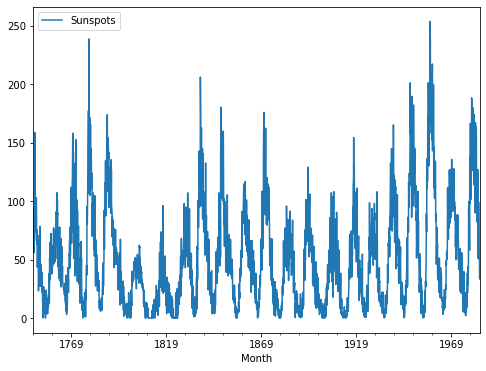

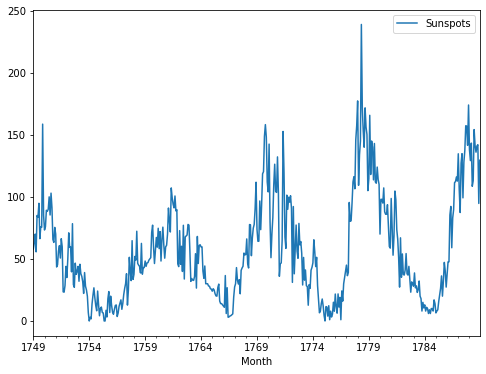

In [3]:
plot_cols = ['Sunspots']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

# Extract Feature

In [4]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [5]:
timestamp_s = timestamp_s+6974035200.0

In [6]:
month = 24*60*60*30
year = (365.2425)*24*60*60

df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of Month signal')

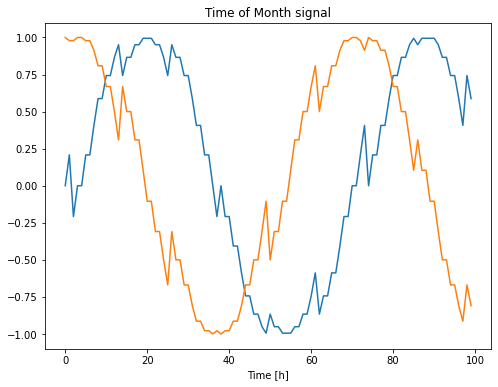

In [7]:
plt.plot(np.array(df['Month sin'])[:100])
plt.plot(np.array(df['Month cos'])[:100])
plt.xlabel('Time [h]')
plt.title('Time of Month signal')

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

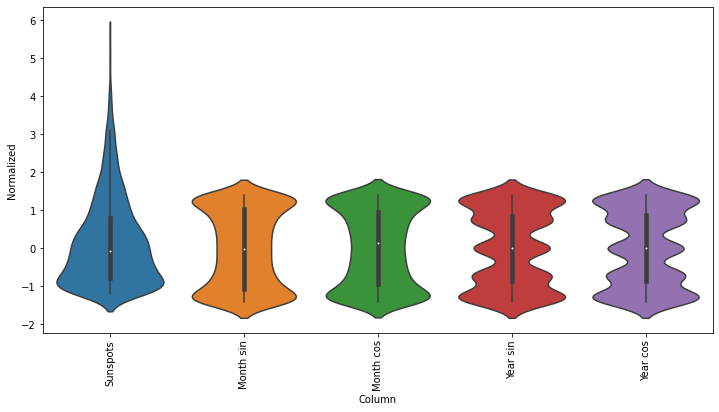

In [10]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Generate window for Timeseries

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            #Get and stack features as tensors
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels



In [201]:
def plot(self, model=None, plot_col='Sunspots', max_subplots=3,num_predict=10):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for plot_ind,n in enumerate([0,1,2]):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices[-num_predict:], predictions[n, -num_predict:, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

#   plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [14]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [116]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [ ]:
tf.keras.callbacks.EarlyStopping()

# Modeling 1

In [215]:
wide_window = WindowGenerator(
    input_width=48, label_width=1, shift=1,
    label_columns=['Sunspots'])


In [216]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(48, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [226]:
val_performance = {}
performance = {}
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
61/61 [==============================] - 2s 18ms/step - loss: 0.1267 - mean_absolute_error: 0.2578 - val_loss: 0.3128 - val_mean_absolute_error: 0.3959
Epoch 2/20
61/61 [==============================] - 1s 12ms/step - loss: 0.1218 - mean_absolute_error: 0.2530 - val_loss: 0.3320 - val_mean_absolute_error: 0.4042
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3351 - mean_absolute_error: 0.4066


In [218]:
lstm_model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 48)                10368     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 49        
Total params: 10,417
Trainable params: 10,417
Non-trainable params: 0
_________________________________________________________________


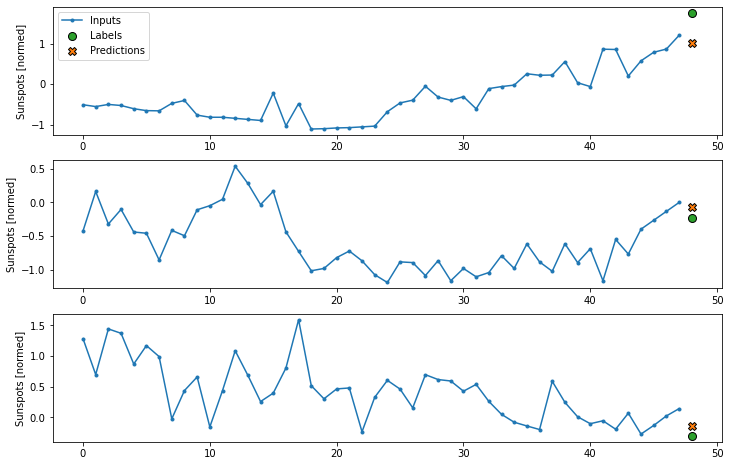

In [219]:
plot_col='Sunspots'
inputs, labels = wide_window.example
plt.figure(figsize=(12, 8))
plot_col_index = wide_window.column_indices[plot_col]
# n= 10
for plot_ind,n in enumerate([0,1,2]):
    plt.subplot(3, 1, plot_ind+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(wide_window.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if wide_window.label_columns:
      label_col_index = wide_window.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    plt.scatter(wide_window.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    predictions = lstm_model(inputs)
    plt.scatter(wide_window.label_indices, predictions[n],
              marker='X', edgecolors='k', label='Predictions',
              c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

# Model 2

In [223]:
wide_window = WindowGenerator(
    input_width=48, label_width=48, shift=1,
    label_columns=['Sunspots'])


lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(48, return_sequences=True),
    tf.keras.layers.LSTM(48, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

val_performance = {}
performance = {}
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

lstm_model.summary()

17/17 [==============================] - 0s 5ms/step - loss: 0.2682 - mean_absolute_error: 0.3668
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 48, 48)            10368     
_________________________________________________________________
lstm_43 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
dense_42 (Dense)             (None, 48, 1)             49        
Total params: 29,041
Trainable params: 29,041
Non-trainable params: 0
_________________________________________________________________


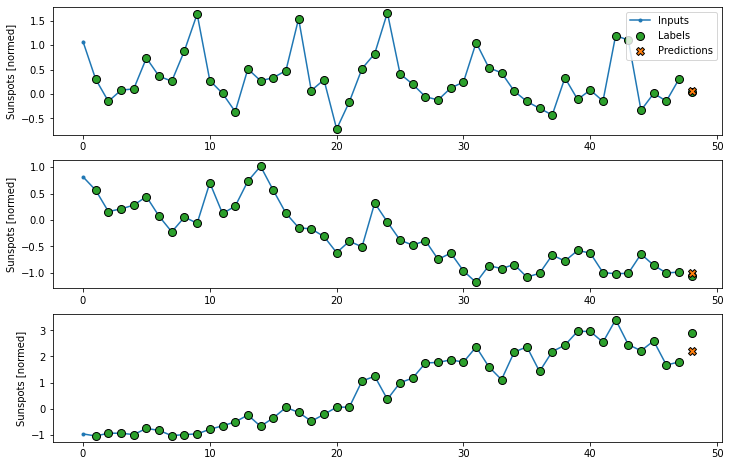

In [224]:
wide_window.plot(lstm_model,num_predict=1)